In [282]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
from matplotlib import pyplot as plt

from sklearn.preprocessing import MaxAbsScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline, Parallel

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV, KFold, learning_curve, RandomizedSearchCV, TimeSeriesSplit, train_test_split
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, IsolationForest, RandomForestRegressor, RandomTreesEmbedding, StackingRegressor

In [594]:
#Data Import

y = pd.read_csv('generation_data.csv', parse_dates=['DateTime'], index_col=["DateTime"])
X = pd.read_csv('features_data.csv', parse_dates=['DateTime'], index_col=["DateTime"])
sample_submission = pd.read_csv("sample_submission.csv")

In [597]:
X.columns = [i.replace(' ', '_').replace("'", '').replace(',', '') for i in X.columns]
#X = X.drop("Hour", axis=1)
X["Month"] = [month for month in X.index.month]
X["Day"] = [day for day in X.index.day]

def SeasonSelector(x):
    if x in (1, 2, 12):
        return 'Winter'
    elif x in (3, 4, 5):
        return 'Spring'
    elif x in (6, 7, 8):
        return 'Summer'
    elif x in (9, 10, 11):
        return 'Autumn'
    
X["Season"] = [SeasonSelector(month)  for month in X.index.month]

**Approach 1: No Time Series Cross Validation, No Scaling, Linear Regression as Base Model, Drop Missing Columns**

In [598]:
X1 = X.drop('WWCode', axis=1)

In [599]:
X1[y.index.max():].index.min()

Timestamp('2021-11-30 23:00:00')

In [600]:
X1_test = X1[y.index.max() + pd.DateOffset(hours=1):]
X1_model = X1[:y.index.max()]

In [601]:
X1_train, X1_val, y_train, y_val = train_test_split(X1_model, y, random_state=421, test_size=0.20)

In [602]:
X1_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20448 entries, 2019-05-26 02:00:00 to 2021-04-04 23:00:00
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   AirTemperature                                 20448 non-null  float64
 1   ComfortTemperature                             20448 non-null  float64
 2   RelativeHumidity                               20448 non-null  float64
 3   WindSpeed                                      20448 non-null  float64
 4   WindDirection                                  20448 non-null  float64
 5   EffectiveCloudCover                            20448 non-null  float64
 6   is_holiday                                     20448 non-null  int64  
 7   Commemoration_of_Ataturk_Youth_and_Sports_Day  20448 non-null  int64  
 8   Democracy_and_National_Unity_Day               20448 non-null  int64  
 9   Labour_Day     

In [120]:
lin_model = LinearRegression()
lin_model.fit(X1_train, y_train)
y_trin_hat = lin_model.predict(X1_train)
lin_pred

,Generation,y_hat
DateTime,,
2019-05-26 02:00:00,0.000000,11.498185
2021-05-13 20:00:00,0.025347,104.983376
2020-01-29 16:00:00,49.050627,89.490078
2020-07-06 05:00:00,1.091121,39.886808
2021-07-02 09:00:00,280.405529,353.932414
...,...,...
2019-05-09 19:00:00,5.105887,34.916153
2019-01-21 12:00:00,70.189786,129.549539
2021-02-06 15:00:00,269.655556,316.709047


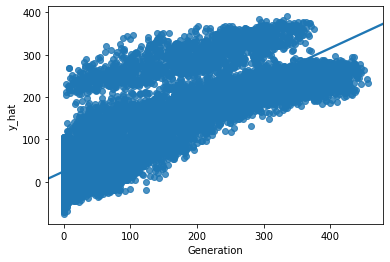

In [122]:
lin_pred = y_train.copy()
lin_pred["y_hat"] = y_trin_hat
sns.regplot(x='Generation', y='y_hat', data=lin_pred);

In [127]:
rmse_lin_reg = np.sqrt(mean_squared_error(lin_pred["Generation"], lin_pred["y_hat"]))
print("RMSE from Linear Regression Model is:", rmse_lin_reg)

RMSE from Linear Regression Model is: 65.54946052601268


**Approach 2: No Time Series Cross Validation, No Scaling, Multiple Models with Default Parameters, Drop Missing Columns**

In [603]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_encoded = pd.DataFrame(ohe.fit_transform(X1_train[["Season"]]))
val_encoded = pd.DataFrame(ohe.transform(X1_val[["Season"]]))
train_encoded.index = X1_train.index
val_encoded.index = X1_val.index
train_encoded.columns = ohe.get_feature_names()
val_encoded.columns = ohe.get_feature_names()

test_encoded = pd.DataFrame(ohe.transform(X1_test[["Season"]]))
test_encoded.index = X1_test.index
test_encoded.columns = ohe.get_feature_names()

In [604]:
X1_train_encoded = X1_train.drop("Season", axis=1).merge(train_encoded, left_index=True, right_index=True, how='left')
X1_val_encoded = X1_val.drop("Season", axis=1).merge(val_encoded, left_index=True, right_index=True, how='left')
X1_test_encoded = X1_test.drop("Season", axis=1).merge(test_encoded, left_index=True, right_index=True, how='left')

X1_train_encoded.head()

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,is_holiday,Commemoration_of_Ataturk_Youth_and_Sports_Day,Democracy_and_National_Unity_Day,Labour_Day,...,Day_Tuesday,Day_Wednesday,Hour,DayGroup,Month,Day,x0_Autumn,x0_Spring,x0_Summer,x0_Winter
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-05-26 02:00:00,15.2,15.6,67.0,0.5,220.0,3.0,0,0,0,0,...,0,0,2,0,5,26,0.0,1.0,0.0,0.0
2021-05-13 20:00:00,26.4,24.2,16.1,0.0,0.0,0.0,1,0,0,0,...,0,0,20,0,5,13,0.0,1.0,0.0,0.0
2020-01-29 16:00:00,8.9,7.5,53.3,2.1,230.0,5.0,0,0,0,0,...,0,1,16,1,1,29,0.0,0.0,0.0,1.0
2020-07-06 05:00:00,20.7,22.4,59.0,3.1,50.0,0.0,0,0,0,0,...,0,0,5,0,7,6,0.0,0.0,1.0,0.0
2021-07-02 09:00:00,28.4,29.2,29.7,1.0,20.0,0.0,0,0,0,0,...,0,0,9,3,7,2,0.0,0.0,1.0,0.0


In [605]:
model_list = [LGBMRegressor(n_jobs=-1, random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), XGBRegressor(n_jobs=-1, random_state=42, objective='reg:squarederror'),
              ExtraTreesRegressor(random_state=42), GradientBoostingRegressor(random_state=42), BaggingRegressor(random_state=42)
             ]

train_rmse = []
train_mae = []
train_r2 = []
val_rmse = []
val_mae = []
val_r2 = []
times = []
counter = 0

print("Prediction started...")
for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(X1_train_encoded, np.ravel(y_train))
    end_time = time.time()
    train_pred = mod.predict(X1_train_encoded)
    val_pred = mod.predict(X1_val_encoded)
    
    train_rmse.append(mean_squared_error(np.ravel(y_train), train_pred, squared=False))
    train_mae.append(mean_absolute_error(np.ravel(y_train), train_pred))
    train_r2.append(r2_score(np.ravel(y_train), train_pred))
    
    val_rmse.append(mean_squared_error(np.ravel(y_val), val_pred, squared=False))
    val_mae.append(mean_absolute_error(np.ravel(y_val), val_pred))
    val_r2.append(r2_score(np.ravel(y_val), val_pred))

    times.append(end_time - start_time)
    print("Model",counter,"is completed")
    counter += 1
print("Prediction is completed...")    

Prediction started...
Model 0 is completed
Model 1 is completed
Model 2 is completed
Model 3 is completed
Model 4 is completed
Model 5 is completed
Prediction is completed...


In [606]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_rmse': train_rmse,
     'train_mae': train_mae,
     'train_r2': train_r2,
     'val_rmse': val_rmse,
     'val_mae': val_mae,
     'val_r2': val_r2,   
     'duration': times
    })

modelsdf.sort_values(by='val_rmse', ascending=True)

,model,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2,duration
0,LGBMRegressor(random_state=42),1.877710e+01,1.038774e+01,0.977647,22.508271,12.189555,0.969297,0.362030
3,"(ExtraTreeRegressor(random_state=1608637542), ...",7.199181e-10,2.474077e-11,1.000000,22.816594,11.334844,0.968450,9.257015
1,"(DecisionTreeRegressor(max_features='auto', ra...",8.551478e+00,4.284850e+00,0.995364,23.603207,11.898321,0.966237,2.734191
5,(DecisionTreeRegressor(random_state=1952926171...,1.026137e+01,4.784698e+00,0.993325,24.547830,12.400991,0.963480,1.337974
4,([DecisionTreeRegressor(criterion='friedman_ms...,2.609736e+01,1.601419e+01,0.956822,27.215828,16.752769,0.955111,3.126003
2,"XGBRegressor(n_jobs=-1, objective='reg:squared...",2.605515e+01,1.579754e+01,0.956961,27.279085,16.609634,0.954902,3.609031


In [323]:
sunset_sunrise = pd.read_csv('ankara_monthly_sunrise_sunset.csv', parse_dates=['SunRise', 'SunSet'])
sunset_sunrise["Sunrise_hour"] = sunset_sunrise["SunRise"].dt.hour
sunset_sunrise["Sunset_hour"] = sunset_sunrise["SunSet"].dt.hour

**Parameter Tuning for the Best Performing Algorithm**

In [607]:
X1_train_encoded.columns

Index(['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed',
       'WindDirection', 'EffectiveCloudCover', 'is_holiday',
       'Commemoration_of_Ataturk_Youth_and_Sports_Day',
       'Democracy_and_National_Unity_Day', 'Labour_Day',
       'National_Sovereignty_and_Childrens_Day', 'New_Years_Day',
       'Ramadan_Feast', 'Ramadan_Feast_Holiday', 'Republic_Day',
       'Sacrifice_Feast', 'Sacrifice_Feast_Holiday', 'Victory_Day',
       'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Hour', 'DayGroup',
       'Month', 'Day', 'x0_Autumn', 'x0_Spring', 'x0_Summer', 'x0_Winter'],
      dtype='object')

In [608]:
lgbm1 = LGBMRegressor(n_jobs=-1, random_state=42, n_estimators=100)

params = {
    "boosting_type": ['gbdt'],
    "n_estimators": [150, 200, 250],
    "min_split_gain": [0.0, 0.0001, 0.001],
    "min_child_samples":[5, 10],
    "max_depth": [15, 30, 50],
    "learning_rate": [0.1],
    "num_leaves": [40, 70, 100]   
}


#define mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

grid1 = GridSearchCV(lgbm1, param_grid=params, cv=10, n_jobs=-1, scoring=mse, verbose=2)
grid1.fit(X1_train_encoded, y_train)

print(grid1.best_params_)

y_train_grid1 = grid1.predict(X1_train_encoded)
y_val_grid1 = grid1.predict(X1_val_encoded)

print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid1, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid1))
print("Train Set R2:", r2_score(y_train, y_train_grid1))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid1, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid1))
print("Val Set R2:", r2_score(y_val, y_val_grid1))

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  6.2min finished


{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 30, 'min_child_samples': 5, 'min_split_gain': 0.001, 'n_estimators': 250, 'num_leaves': 100}
Train Set RMSE: 6.645599723462448
Train Set MAE: 3.7452072830187673
Train Set R2: 0.9972001214653519

Val Set RMSE: 19.732556475373833
Val Set MAE: 10.162215029626307
Val Set R2: 0.976402462968568


In [615]:
#v1 SUBMIT ET
y_train_grid1adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_grid1])
y_val_grid1adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_grid1])

y_train_grid1adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, y_train_grid1adj)]
y_val_grid1adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, y_val_grid1adj)]

print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid1adj, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid1adj))
print("Train Set R2:", r2_score(y_train, y_train_grid1adj))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid1adj, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid1adj))
print("Val Set R2:", r2_score(y_val, y_val_grid1adj))

Train Set RMSE: 6.624749168899182
Train Set MAE: 3.5217521217850325
Train Set R2: 0.9972176631291771

Val Set RMSE: 19.71607317283844
Val Set MAE: 9.877977370189335
Val Set R2: 0.9764418702176195


In [623]:
#v2 
y_train_grid1adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_grid1])
y_val_grid1adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_grid1])

y_train_grid1adj2 = []
y_val_grid1adj2 = []

for month, hour, generation in zip(y_train.index.month, y_train.index.hour, y_train_grid1adj):
    sr = sunset_sunrise[sunset_sunrise["Month"] == month]["Sunrise_hour"].values[0]
    ss = sunset_sunrise[sunset_sunrise["Month"] == month]["Sunset_hour"].values[0]
    res = generation
    if hour >= sr & hour <= ss:
        res = generation
    else:
        res = generation * 0.0
    y_train_grid1adj2.append(res)
    
for month, hour, generation in zip(y_val.index.month, y_val.index.hour, y_val_grid1adj):
    sr = sunset_sunrise[sunset_sunrise["Month"] == month]["Sunrise_hour"].values[0]
    ss = sunset_sunrise[sunset_sunrise["Month"] == month]["Sunset_hour"].values[0]
    res = generation
    if hour >= sr & hour <= ss:
        res = generation
    else:
        res = generation * 0.0
    y_val_grid1adj2.append(res)


print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid1adj2, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid1adj2))
print("Train Set R2:", r2_score(y_train, y_train_grid1adj2))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid1adj2, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid1adj2))
print("Val Set R2:", r2_score(y_val, y_val_grid1adj2))

Train Set RMSE: 6.63290374713814
Train Set MAE: 3.622052851555746
Train Set R2: 0.9972108092099624

Val Set RMSE: 19.72138100116965
Val Set MAE: 9.999989210502697
Val Set R2: 0.9764291841883942


In [624]:
#Predict the test data with v1 adjustment
y_test_grid1 = grid1.predict(X1_test_encoded)
y_test_grid1adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_test_grid1])
y_test_grid1adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(X1_test.index.hour, y_test_grid1adj)]

In [625]:
print("Max:", y_test_grid1.max())
print("Min:", y_test_grid1.min())

Max: 298.0960750054518
Min: -6.6746536192917025


In [626]:
print("Max:", max(y_test_grid1adj))
print("Min:", min(y_test_grid1adj))

Max: 298.0960750054518
Min: 0


In [627]:
y_test_grid1adj_df = pd.DataFrame(y_test_grid1adj, index=X1_test.index)
y_test_grid1adj_df.columns = ["Generation"]
y_test_grid1adj_df.index = y_test_grid1adj_df.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission1 = sample_submission.drop("Generation", axis=1)
sample_submission1["Generation"] = y_test_grid1adj_df["Generation"].values
sample_submission1.to_csv('approach1_predictions.csv', index=False)

**Approach 3: No Time Series Cross Validation, Continuous Features Scaling, LGBM with Hyperparameter Tuning, Drop Missing Columns**

In [628]:
contiuous = ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 
        'WindDirection', 'EffectiveCloudCover']

scaler = Pipeline(steps=[
        ('standard_scaler', StandardScaler())])

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('scaler',  scaler, contiuous)
        ])

lgbm2 = LGBMRegressor(n_jobs=-1, random_state=42, n_estimators=100)

params = {
    "lgbm__boosting_type": ['gbdt'],
    "lgbm__n_estimators": [150, 200, 250],
    "lgbm__min_split_gain": [0.0, 0.0001, 0.001],
    "lgbm__min_child_samples":[5, 10],
    "lgbm__max_depth": [15, 30, 50],
    "lgbm__learning_rate": [0.1],
    "lgbm__num_leaves": [40, 70, 100]   
}

pipe1 = Pipeline(steps=([('preprocessor', preprocessor), ('lgbm', lgbm2)]))

#define mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

grid2 = GridSearchCV(pipe1, param_grid=params, cv=10, n_jobs=-1, scoring=mse, verbose=2)
grid2.fit(X1_train_encoded, y_train)

print(grid2.best_params_)

y_train_grid2 = grid2.predict(X1_train_encoded)
y_val_grid2 = grid2.predict(X1_val_encoded)

print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid2, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid2))
print("Train Set R2:", r2_score(y_train, y_train_grid2))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid2, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid2))
print("Val Set R2:", r2_score(y_val, y_val_grid2))

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  5.7min finished
c:\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'lgbm__boosting_type': 'gbdt', 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 50, 'lgbm__min_child_samples': 5, 'lgbm__min_split_gain': 0.0, 'lgbm__n_estimators': 250, 'lgbm__num_leaves': 100}
Train Set RMSE: 6.506655983994964
Train Set MAE: 3.6980706213213503
Train Set R2: 0.9973159752056044

Val Set RMSE: 19.47081044431672
Val Set MAE: 10.014957236068836
Val Set R2: 0.9770243384578311


In [632]:
#SUBMIT ET
total_capacity = 523.005001
y_train_grid2adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_grid2])
y_val_grid2adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_grid2])

y_train_grid2adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, y_train_grid2adj)]
y_val_grid2adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, y_val_grid2adj)]

print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid2adj, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid2adj))
print("Train Set R2:", r2_score(y_train, y_train_grid2adj))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid2adj, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid2adj))
print("Val Set R2:", r2_score(y_val, y_val_grid2adj))

Train Set RMSE: 6.484791412177272
Train Set MAE: 3.4672339187569605
Train Set R2: 0.997333983365918

Val Set RMSE: 19.453702662463876
Val Set MAE: 9.718125394512985
Val Set R2: 0.977064695270606


In [696]:
#Predict the test data
y_test_grid2 = grid2.predict(X1_test_encoded)
y_test_grid2adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_test_grid2])
y_test_grid2adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(X1_test_encoded.index.hour, y_test_grid2adj)]


y_test_grid2adj_df = pd.DataFrame(y_test_grid2adj, index=X1_test_encoded.index)
y_test_grid2adj_df.columns = ["Generation"]
y_test_grid2adj_df.index = y_test_grid2adj_df.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission2 = sample_submission.drop("Generation", axis=1)
sample_submission2["Generation"] = y_test_grid2adj_df["Generation"].values
sample_submission2.to_csv('approach3_predictions.csv', index=False)

**Error Investigation**

In [634]:
validation_error= y_val.copy()
validation_error["prediction"] = y_val_grid2adj
validation_error["Error"] = validation_error["prediction"] - validation_error["Generation"] +0.0000000000001
validation_error["AbsError"] = abs(validation_error["prediction"] - validation_error["Generation"]+0.0000000000001)
validation_error["PercError"] = (validation_error["AbsError"] / (validation_error["Generation"]+0.0000000000001)) 
validation_error

,Generation,prediction,Error,AbsError,PercError
DateTime,,,,,
2020-07-29 02:00:00,0.000000,0.000000,1.000000e-13,1.000000e-13,1.000000
2021-10-28 19:00:00,0.000429,0.000000,-4.290000e-04,4.290000e-04,1.000000
2019-03-03 15:00:00,169.073239,226.642047,5.756881e+01,5.756881e+01,0.340496
2019-12-07 18:00:00,0.000000,0.000000,1.000000e-13,1.000000e-13,1.000000
2019-07-15 19:00:00,12.930809,11.211839,-1.718970e+00,1.718970e+00,0.132936
...,...,...,...,...,...
2020-12-25 00:00:00,0.001202,0.000000,-1.202000e-03,1.202000e-03,1.000000
2021-02-15 01:00:00,0.004301,0.000000,-4.301000e-03,4.301000e-03,1.000000
2020-09-06 19:00:00,0.163590,1.494993,1.331403e+00,1.331403e+00,8.138641


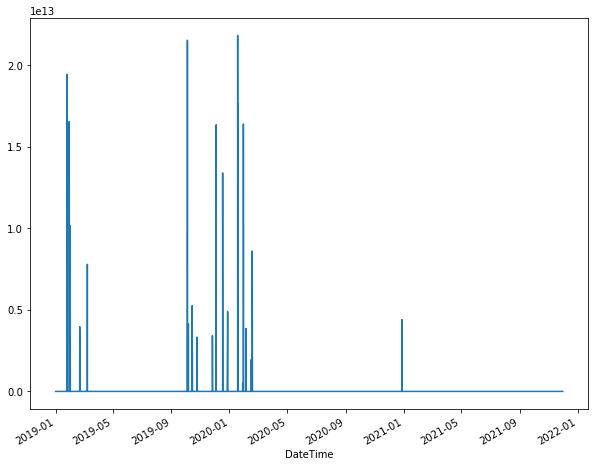

In [635]:
plt.figure(figsize=(10, 8))
validation_error["PercError"].plot();

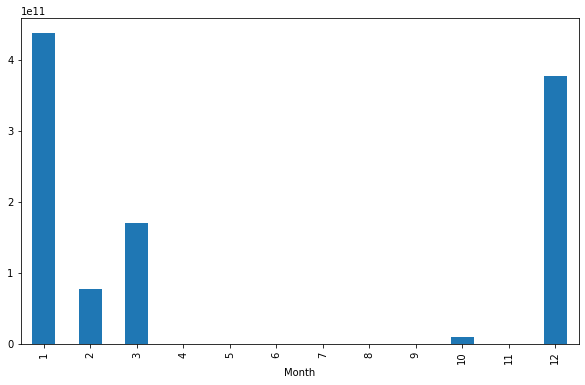

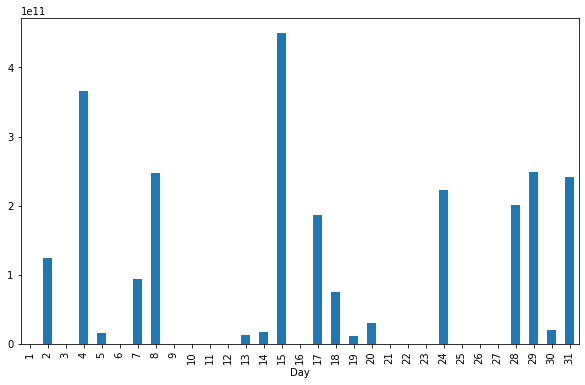

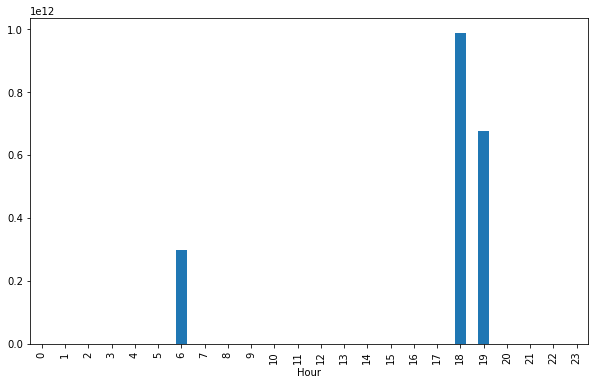

In [524]:
validation_error["Month"] = validation_error.index.month
validation_error["Day"] = validation_error.index.day
validation_error["Hour"] = validation_error.index.hour

for col in ["Month", "Day", "Hour"]:
    plt.figure(figsize=(10, 6))
    validation_error.groupby(col)["PercError"].mean().plot(kind="bar")
    plt.show()

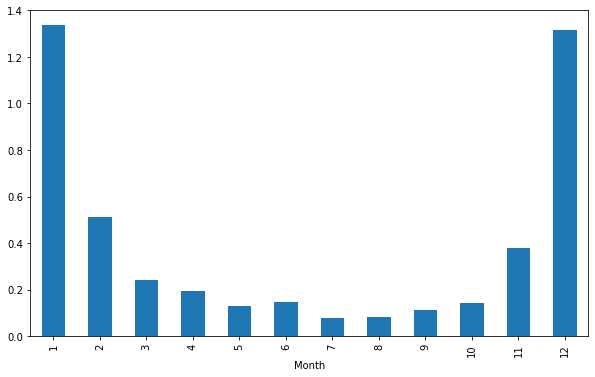

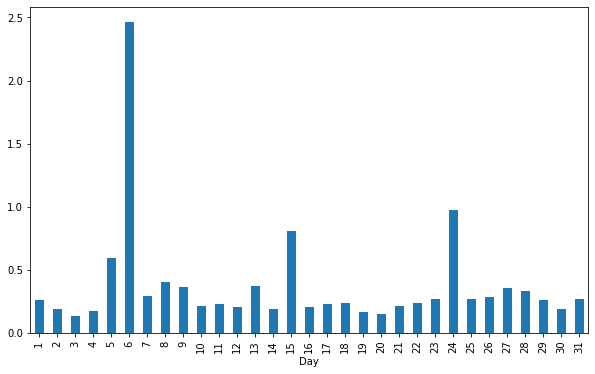

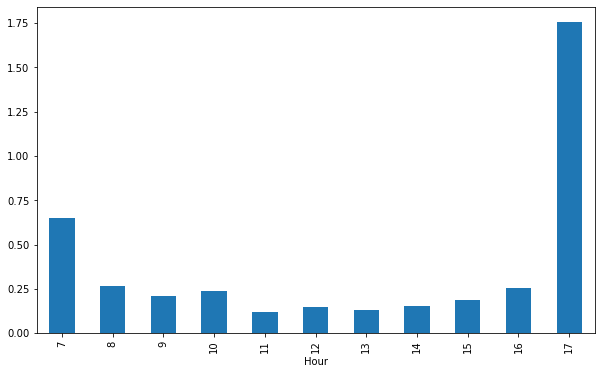

In [636]:
validation_error["Month"] = validation_error.index.month
validation_error["Day"] = validation_error.index.day
validation_error["Hour"] = validation_error.index.hour

for col in ["Month", "Day", "Hour"]:
    plt.figure(figsize=(10, 6))
    validation_error[(validation_error["Hour"] > 6) & (validation_error["Hour"] < 18)].groupby(col)["PercError"].mean().plot(kind="bar")
    plt.show()

In [74]:
#Predict the test data
y_test_grid2adj_pred_df = y_test_grid2adj_df.copy()
y_test_grid2adj_df.index = pd.to_datetime(y_test_grid2adj_df.index)
y_test_grid2adj_pred_df["Generation"] = [pred if  6 < hour < 19 else 0 for hour, pred in zip(y_test_grid2adj_pred_df.index.hour, y_test_grid2adj_pred_df["Generation"])]


y_test_grid2adj_pred_df.index = y_test_grid2adj_pred_df.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission3 = sample_submission.drop("Generation", axis=1)
sample_submission3["Generation"] = y_test_grid2adj_pred_df["Generation"].values
sample_submission3.to_csv('approach3_adjusted_predictions.csv', index=False)

**Approach 4:** Eliminate the data hours before 06:00 and after 18:00

**No Time Series Cross Validation, Continuous Features Scaling, LGBM with Hyperparameter Tuning, Drop Missing Columns**

In [526]:
X2_model = X1_model[(X1_model.index.hour > 6) & (X1_model.index.hour < 19)]
y2 = y[(y.index.hour > 6) & (y.index.hour < 19)]
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_model, y2, random_state=421, test_size=0.20)

In [528]:
contiuous = ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 
        'WindDirection', 'EffectiveCloudCover']

scaler = Pipeline(steps=[
        ('standard_scaler', StandardScaler())])

encoder = Pipeline(steps=[('ohe', OneHotEncoder())])

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('scaler',  scaler, contiuous),
            ('encoder', encoder, ['Season'])
        ])

lgbm3 = LGBMRegressor(n_jobs=-1, random_state=42, n_estimators=100)

params = {
    "lgbm__boosting_type": ['gbdt'],
    "lgbm__n_estimators": [150, 200, 250],
    "lgbm__min_split_gain": [0.0, 0.0001, 0.001],
    "lgbm__min_child_samples":[5, 10],
    "lgbm__max_depth": [15, 30, 50],
    "lgbm__learning_rate": [0.1],
    "lgbm__num_leaves": [40, 70, 100]   
}

pipe2 = Pipeline(steps=([('preprocessor', preprocessor), ('lgbm', lgbm3)]))

#define mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

grid3 = GridSearchCV(pipe2, param_grid=params, cv=10, n_jobs=-1, scoring=mse, verbose=2)
grid3.fit(X2_train, y2_train)

print(grid3.best_params_)

y_train_grid3 = grid3.predict(X2_train)
y_val_grid3 = grid3.predict(X2_val)

print("Train Set RMSE:", mean_squared_error(y2_train, y_train_grid3, squared=False))
print("Train Set MAE:", mean_absolute_error(y2_train, y_train_grid3))
print("Train Set R2:", r2_score(y2_train, y_train_grid3))

print()
print("Val Set RMSE:", mean_squared_error(y2_val, y_val_grid3, squared=False))
print("Val Set MAE:", mean_absolute_error(y2_val, y_val_grid3))
print("Val Set R2:", r2_score(y2_val, y_val_grid3))

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  4.1min finished
c:\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'lgbm__boosting_type': 'gbdt', 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 15, 'lgbm__min_child_samples': 5, 'lgbm__min_split_gain': 0.001, 'lgbm__n_estimators': 250, 'lgbm__num_leaves': 100}
Train Set RMSE: 10.933557041120718
Train Set MAE: 7.837657398363388
Train Set R2: 0.9925454449948146

Val Set RMSE: 29.997421531147037
Val Set MAE: 21.49092251148442
Val Set R2: 0.9442676801910016


In [529]:
total_capacity = 523.005001
y_train_grid3adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_grid3])
y_val_grid3adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_grid3])

print("Train Set RMSE:", mean_squared_error(y2_train, y_train_grid3adj, squared=False))
print("Train Set MAE:", mean_absolute_error(y2_train, y_train_grid3adj))
print("Train Set R2:", r2_score(y2_train, y_train_grid3adj))

print()
print("Val Set RMSE:", mean_squared_error(y2_val, y_val_grid3adj, squared=False))
print("Val Set MAE:", mean_absolute_error(y2_val, y_val_grid3adj))
print("Val Set R2:", r2_score(y2_val, y_val_grid3adj))

Train Set RMSE: 10.925090577628023
Train Set MAE: 7.791253879076099
Train Set R2: 0.992556985480922

Val Set RMSE: 29.98951520887646
Val Set MAE: 21.426929512907694
Val Set R2: 0.9442970546898813


In [532]:
appr4_train_preds["preds"] = pd.Series(y_train_grid3adj, index=y2_train.index)
appr4_val_preds["preds"] = pd.Series(y_val_grid3adj, index=y2_val.index)

appr4_train_preds = y_train.merge(appr4_train_preds, how='left', left_index=True, right_index=True).fillna(0)
appr4_val_preds = y_val.merge(appr4_val_preds, how='left', left_index=True, right_index=True).fillna(0)

In [533]:
print("Train Set RMSE:", mean_squared_error(y_train, appr4_train_preds["preds"], squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, appr4_train_preds["preds"]))
print("Train Set R2:", r2_score(y_train, appr4_train_preds["preds"]))

print()
print("Val Set RMSE:", mean_squared_error(y_val, appr4_val_preds["preds"], squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, appr4_val_preds["preds"]))
print("Val Set R2:", r2_score(y_val, appr4_val_preds["preds"]))

Train Set RMSE: 69.74714602390551
Train Set MAE: 21.462940944227867
Train Set R2: 0.6915933633161107

Val Set RMSE: 142.90670637116364
Val Set MAE: 76.9491074708728
Val Set R2: -0.2376709210527186


In [113]:
X2_test = X1_test[(X1_test.index.hour > 6) & (X1_test.index.hour < 19)]

In [138]:
#Predict the test data
y_test_grid3 = grid3.predict(X2_test)
y_test_grid3adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_test_grid3])

y_test_grid3adj_df = pd.DataFrame(y_test_grid3adj, index=X2_test.index)
y_test_grid3adj_df.columns = ["Generation"]

appr4_test_preds = X1_test[["AirTemperature"]].merge(y_test_grid3adj_df, how='left', left_index=True, right_index=True).fillna(0)

appr4_test_preds.index = appr4_test_preds.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission4 = sample_submission.drop("Generation", axis=1)
sample_submission4["Generation"] = appr4_test_preds["Generation"].values
sample_submission4.to_csv('approach4_predictions.csv', index=False)

(array([4706.,   63.,   52.,   42.,   55.,   48.,   44.,   59.,   35.,
           8.]), array([  0.        ,  44.46561274,  88.93122547, 133.39683821,
        177.86245095, 222.32806368, 266.79367642, 311.25928916,
        355.72490189, 400.19051463, 444.65612737]), <a list of 10 Patch objects>)

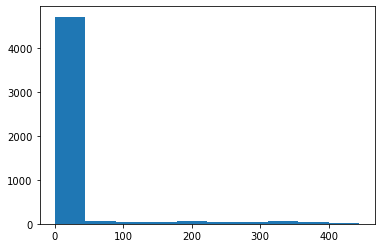

In [534]:
#appr4_val_preds["preds"].idxmax()-->'2020-04-12 14:00:00'
plt.hist(appr4_val_preds["preds"])

In [535]:
appr4_validation_error= y_val.copy()
appr4_validation_error["prediction"] = appr4_val_preds["preds"]
appr4_validation_error["Error"] = appr4_validation_error["prediction"] - appr4_validation_error["Generation"] +0.0000000001
appr4_validation_error["AbsError"] = abs(appr4_validation_error["prediction"] - appr4_validation_error["Generation"]+0.0000000001)
appr4_validation_error["PercError"] = (appr4_validation_error["AbsError"] / (appr4_validation_error["Generation"]+0.0000000001)) 
appr4_validation_error

,Generation,prediction,Error,AbsError,PercError
DateTime,,,,,
2020-07-29 02:00:00,0.000000,0.0,1.000000e-10,1.000000e-10,1.000000
2021-10-28 19:00:00,0.000429,0.0,-4.289999e-04,4.289999e-04,1.000000
2019-03-03 15:00:00,169.073239,0.0,-1.690732e+02,1.690732e+02,1.000000
2019-12-07 18:00:00,0.000000,0.0,1.000000e-10,1.000000e-10,1.000000
2019-07-15 19:00:00,12.930809,0.0,-1.293081e+01,1.293081e+01,1.000000
...,...,...,...,...,...
2020-12-25 00:00:00,0.001202,0.0,-1.202000e-03,1.202000e-03,1.000000
2021-02-15 01:00:00,0.004301,0.0,-4.301000e-03,4.301000e-03,1.000000
2020-09-06 19:00:00,0.163590,0.0,-1.635903e-01,1.635903e-01,1.000000


**Approach 5: XGB Regressor with Hyperopt**

In [637]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [658]:
def objective(space):
    # Instantiate the regressor
    reg = XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            gamma = space['gamma'],
                            reg_lambda = space['reg_lambda'],
                            objective='reg:squarederror')
    
    eval_set  = [( X1_train_encoded, y_train), ( X1_val_encoded, y_val)]
    
    # Fit the regressor
    reg.fit(X1_train_encoded, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = reg.predict(X1_val_encoded)
    
    # Calculate our Metric - RMSE
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    # return the loss
    return {'loss': rmse, 'status': STATUS_OK }

In [659]:
space ={'max_depth': hp.quniform("x_max_depth", 3, 50, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 100, 1),
        'subsample': hp.uniform ('x_subsample', 0.6, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1, 0.9),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.6, 1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0, 1),
        'learning_rate': hp.uniform('x_learning_rate', 0.001, 0.1)
       }

In [660]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)
print(best)

100%|█████████████████████████████████████████████████| 10/10 [13:39<00:00, 81.91s/trial, best loss: 20.05030934861714]
{'x_colsample_bytree': 0.6391485870776347, 'x_gamma': 0.11441401979886923, 'x_learning_rate': 0.07641585474881568, 'x_max_depth': 26.0, 'x_min_child': 41.0, 'x_reg_lambda': 0.5316110522966462, 'x_subsample': 0.7575872976860692}


In [662]:
HyperoptXGB = XGBRegressor(x_colsample_bytree =  0.6391485870776347, 
                           x_gamma = 0.11441401979886923, 
                           x_max_depth = 26.0, 
                           x_min_child = 41.0, 
                           x_reg_lambda = 0.5316110522966462, 
                           x_subsample = 0.575872976860692,
                           seed=42,
                           objective='reg:squarederror',
                           learning_rate=0.07641585474881568,
                           n_estimators =1000
                           )


HyperoptXGB.fit(X1_train_encoded, y_train)
y_train_hyperopt = HyperoptXGB.predict(X1_train_encoded)
y_val_hyperopt = HyperoptXGB.predict(X1_val_encoded)

print("Train Set RMSE:", mean_squared_error(y_train, y_train_hyperopt, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_hyperopt))
print("Train Set R2:", r2_score(y_train, y_train_hyperopt))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_hyperopt, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_hyperopt))
print("Val Set R2:", r2_score(y_val, y_val_hyperopt))

Train Set RMSE: 21.22827883853877
Train Set MAE: 12.538588760761286
Train Set R2: 0.9714306473820803

Val Set RMSE: 23.91301177948638
Val Set MAE: 14.090100482789873
Val Set R2: 0.9653447909509345


In [663]:
total_capacity = 523.005001
y_train_hyperopt_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_hyperopt])
y_val_hyperopt_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_hyperopt])

y_train_hyperopt_adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, y_train_hyperopt_adj)]
y_val_hyperopt_adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, y_val_hyperopt_adj)]

print("Train Set RMSE:", mean_squared_error(y_train, y_train_hyperopt_adj, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_hyperopt_adj))
print("Train Set R2:", r2_score(y_train, y_train_hyperopt_adj))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_hyperopt_adj, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_hyperopt_adj))
print("Val Set R2:", r2_score(y_val, y_val_hyperopt_adj))

Train Set RMSE: 21.028074922030505
Train Set MAE: 11.105870948107682
Train Set R2: 0.9719669814955658

Val Set RMSE: 23.69092866567368
Val Set MAE: 12.611401570168956
Val Set R2: 0.9659854963867838


In [195]:
#Predict the test data
y_test_hyperopt = HyperoptXGB.predict(X1_test)
y_test_hyperopt_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_test_hyperopt])

y_test_hyperopt_adj_df = pd.DataFrame(y_test_hyperopt_adj, index=X1_test.index)
y_test_hyperopt_adj_df.columns = ["Generation"]
y_test_hyperopt_adj_df.index = y_test_hyperopt_adj_df.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission5 = sample_submission.drop("Generation", axis=1)
sample_submission5["Generation"] = y_test_hyperopt_adj_df["Generation"].values
sample_submission5.to_csv('approach5_hyperopt_xgb_predictions.csv', index=False)

**Approach 6: XGB Regressor with Hyperopt, Day Flags Removed**

In [544]:
X1_test.columns

Index(['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed',
       'WindDirection', 'EffectiveCloudCover', 'is_holiday',
       'Commemoration_of_Ataturk_Youth_and_Sports_Day',
       'Democracy_and_National_Unity_Day', 'Labour_Day',
       'National_Sovereignty_and_Childrens_Day', 'New_Years_Day',
       'Ramadan_Feast', 'Ramadan_Feast_Holiday', 'Republic_Day',
       'Sacrifice_Feast', 'Sacrifice_Feast_Holiday', 'Victory_Day',
       'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Hour', 'DayGroup',
       'Month', 'Season'],
      dtype='object')

In [664]:
X3_train = X1_train_encoded.drop(['Commemoration_of_Ataturk_Youth_and_Sports_Day',
                          'Democracy_and_National_Unity_Day', 'Labour_Day',
                          'National_Sovereignty_and_Childrens_Day', 'New_Years_Day',
                          'Ramadan_Feast', 'Ramadan_Feast_Holiday', 'Republic_Day',
                          'Sacrifice_Feast', 'Sacrifice_Feast_Holiday', 'Victory_Day', 
                          'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
                          'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'], axis=1)

X3_val = X1_val_encoded.drop(['Commemoration_of_Ataturk_Youth_and_Sports_Day',
                          'Democracy_and_National_Unity_Day', 'Labour_Day',
                          'National_Sovereignty_and_Childrens_Day', 'New_Years_Day',
                          'Ramadan_Feast', 'Ramadan_Feast_Holiday', 'Republic_Day',
                          'Sacrifice_Feast', 'Sacrifice_Feast_Holiday', 'Victory_Day', 
                          'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
                          'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'], axis=1)


In [666]:
def objective(space):
    # Instantiate the regressor
    reg = XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            gamma = space['gamma'],
                            reg_lambda = space['reg_lambda'],
                            objective='reg:squarederror')
    
    eval_set  = [( X3_train, y_train), ( X3_val, y_val)]
    
    # Fit the regressor
    reg.fit(X3_train, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = reg.predict(X3_val)
    
    # Calculate our Metric - RMSE
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    # return the loss
    return {'loss': rmse, 'status': STATUS_OK }

space ={'max_depth': hp.quniform("x_max_depth", 3, 40, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 50, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1, 0.8),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.5, 1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0, 1),
        'learning_rate': hp.uniform('x_learning_rate', 0.001, 0.1)        
       }

trials_appr6 = Trials()
best_appr6 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials_appr6)
print(best_appr6)

100%|████████████████████████████████████████████████| 20/20 [15:52<00:00, 47.60s/trial, best loss: 20.915033702935123]
{'x_colsample_bytree': 0.9876384229632607, 'x_gamma': 0.6813881713928129, 'x_learning_rate': 0.09867165724986336, 'x_max_depth': 35.0, 'x_min_child': 44.0, 'x_reg_lambda': 0.9425632826295158, 'x_subsample': 0.8162990438351867}


In [667]:
HyperoptXGB_appr6 = XGBRegressor(x_colsample_bytree =  0.9876384229632607, 
                           x_gamma = 0.6813881713928129, 
                           x_max_depth = 35.0, 
                           x_learning_rate = 0.09867165724986336,
                           x_min_child = 44.0, 
                           x_reg_lambda = 0.9425632826295158, 
                           x_subsample = 0.8162990438351867,
                           seed=42,
                           objective='reg:squarederror')


HyperoptXGB_appr6.fit(X3_train, y_train)
y_train_hyperopt_appr6 = HyperoptXGB_appr6.predict(X3_train)
y_val_hyperopt_appr6 = HyperoptXGB_appr6.predict(X3_val)

print("Train Set RMSE:", mean_squared_error(y_train, y_train_hyperopt_appr6, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_hyperopt_appr6))
print("Train Set R2:", r2_score(y_train, y_train_hyperopt_appr6))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_hyperopt_appr6, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_hyperopt_appr6))
print("Val Set R2:", r2_score(y_val, y_val_hyperopt_appr6))

total_capacity = 523.005001
y_train_hyperopt_appr6_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_hyperopt_appr6])
y_val_hyperopt_appr6_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_hyperopt_appr6])

y_train_hyperopt_appr6_adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, y_train_hyperopt_appr6_adj)]
y_val_hyperopt_appr6_adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, y_val_hyperopt_appr6_adj)]
print()
print("Adj Train Set RMSE:", mean_squared_error(y_train, y_train_hyperopt_appr6_adj, squared=False))
print("Adj Train Set MAE:", mean_absolute_error(y_train, y_train_hyperopt_appr6_adj))
print("Adj Train Set R2:", r2_score(y_train, y_train_hyperopt_appr6_adj))

print()
print("Adj Val Set RMSE:", mean_squared_error(y_val, y_val_hyperopt_appr6_adj, squared=False))
print("Adj Val Set MAE:", mean_absolute_error(y_val, y_val_hyperopt_appr6_adj))
print("Adj Val Set R2:", r2_score(y_val, y_val_hyperopt_appr6_adj))

Train Set RMSE: 26.13136512084827
Train Set MAE: 16.01558754116334
Train Set R2: 0.9567092581052168

Val Set RMSE: 27.311729871515556
Val Set MAE: 16.785027084802554
Val Set R2: 0.9547937602313549

Adj Train Set RMSE: 25.9110197399407
Adj Train Set MAE: 14.200560980716403
Adj Train Set R2: 0.9574362540245449

Adj Val Set RMSE: 27.11194968020756
Adj Val Set MAE: 15.046446805326447
Adj Val Set R2: 0.9554526917670816


**Approach 7: LGBM Regressor with Hyperopt, Day Flags Removed**

In [683]:
def objective_lgbm(space_lgbm):
    # Instantiate the regressor
    reg = LGBMRegressor(boosting_type=space_lgbm['boosting_type']["boosting_type"],
                        n_estimators =1000,
                        colsample_bytree = space_lgbm['colsample_bytree'],
                        max_depth = int(space_lgbm['max_depth']),
                        min_child_weight = space_lgbm['min_child_weight'],
                        subsample = space_lgbm['subsample'],
                        reg_lambda = space_lgbm['reg_lambda'],
                        learning_rate = space_lgbm['learning_rate'],
                        min_child_samples = space_lgbm['min_child_samples'],
                        min_split_gain = space_lgbm['min_split_gain'],
                        num_leaves = space_lgbm['num_leaves']
                        )
    
    eval_set  = [( X3_train, y_train), ( X3_val, y_val)]
    
    # Fit the classsifier
    reg.fit(X3_train, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = reg.predict(X3_val)
    
    # Calculate our Metric - RMSE
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    # return the loss
    return {'loss': rmse, 'status': STATUS_OK }

In [686]:
space_lgbm ={'boosting_type': hp.choice('boosting_type',
                                   [{'boosting_type': 'gbdt'},
                                    {'boosting_type': 'goss'}
                                   ]),
            'max_depth': hp.quniform("x_max_depth", 3, 500, 1),
            'min_child_weight': hp.quniform ('x_min_child_weight', 0.00001, 1, 1),
            'subsample': hp.uniform ('x_subsample', 0.5, 1),
            'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.5, 1),
            'reg_lambda' : hp.uniform ('x_reg_lambda', 0, 1),
            'min_child_samples': hp.choice('x_min_child_samples', np.arange(2, 500, dtype=int)),
            'min_split_gain': hp.uniform('x_min_split_gain', 0, 0.1),
            'num_leaves': hp.choice('x_num_leaves', np.arange(2, 500, dtype=int)),
            'learning_rate': hp.uniform('x_learning_rate', 0.00001, 0.1) 
           }

trials_appr7 = Trials()
best_appr7 = fmin(fn=objective_lgbm,
            space=space_lgbm,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials_appr7)
print(best_appr7)

100%|██████████████████████████████████████████████| 100/100 [06:16<00:00,  3.77s/trial, best loss: 20.635244167028233]
{'boosting_type': 0, 'x_colsample_bytree': 0.8305823781062245, 'x_learning_rate': 0.03848668327760869, 'x_max_depth': 377.0, 'x_min_child_samples': 30, 'x_min_child_weight': 0.0, 'x_min_split_gain': 0.007390021910309094, 'x_num_leaves': 102, 'x_reg_lambda': 0.11995151410610286, 'x_subsample': 0.5552565639136166}


In [691]:
HyperoptLGBM_appr7 = LGBMRegressor(x_boostin_type='gbdt', 
                                   x_colsample_bytree = 0.8305823781062245, 
                                   x_learning_rate = 0.03848668327760869,
                                   x_max_depth = 377.0, 
                                   x_min_child = 30.0, 
                                   x_min_child_weight = 0,
                                   x_min_child_samples = 17, 
                                   x_min_split_gain = 0.007390021910309094,
                                   x_num_leaves = 102, 
                                   x_reg_lambda = 0.11995151410610286, 
                                   x_subsample = 0.5552565639136166,
                                   seed=42
                                   )


HyperoptLGBM_appr7.fit(X3_train, y_train)
y_train_hyperopt_appr7 = HyperoptLGBM_appr7.predict(X3_train)
y_val_hyperopt_appr7 = HyperoptLGBM_appr7.predict(X3_val)

print("Train Set RMSE:", mean_squared_error(y_train, y_train_hyperopt_appr7, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_hyperopt_appr7))
print("Train Set R2:", r2_score(y_train, y_train_hyperopt_appr7))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_hyperopt_appr7, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_hyperopt_appr7))
print("Val Set R2:", r2_score(y_val, y_val_hyperopt_appr7))

y_train_hyperopt_appr7_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_hyperopt_appr7])
y_val_hyperopt_appr7_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_hyperopt_appr7])
y_train_hyperopt_appr7_adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, y_train_hyperopt_appr7_adj)]
y_val_hyperopt_appr7_adj = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, y_val_hyperopt_appr7_adj)]
print()
print("Adj Train Set RMSE:", mean_squared_error(y_train, y_train_hyperopt_appr7_adj, squared=False))
print("Adj Train Set MAE:", mean_absolute_error(y_train, y_train_hyperopt_appr7_adj))
print("Adj Train Set R2:", r2_score(y_train, y_train_hyperopt_appr7_adj))

print()
print("Adj Val Set RMSE:", mean_squared_error(y_val, y_val_hyperopt_appr7_adj, squared=False))
print("Adj Val Set MAE:", mean_absolute_error(y_val, y_val_hyperopt_appr7_adj))
print("Adj Val Set R2:", r2_score(y_val, y_val_hyperopt_appr7_adj))


Train Set RMSE: 19.072911586059682
Train Set MAE: 10.474097332625103
Train Set R2: 0.9769375828460577

Val Set RMSE: 22.849041809705064
Val Set MAE: 12.33231626450665
Val Set R2: 0.968360038082401

Adj Train Set RMSE: 19.044907063844636
Adj Train Set MAE: 10.059270922766709
Adj Train Set R2: 0.9770052576551546

Adj Val Set RMSE: 22.82882837994658
Adj Val Set MAE: 11.940090024284792
Adj Val Set R2: 0.9684159939743683


In [559]:
#Predict the test data
X3_test = X1_test_encoded[X3_train.columns]

y_test_appr7 = HyperoptLGBM_appr7.predict(X3_test)
y_test_appr7_adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_test_appr7])
y_test_appr7_adj_2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(X3_test.index.hour, y_test_appr7_adj)]


y_test_appr7_adj_2_df = pd.DataFrame(y_test_appr7_adj_2, index=X3_test.index)
y_test_appr7_adj_2_df.columns = ["Generation"]
y_test_appr7_adj_2_df.index = y_test_appr7_adj_2_df.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission7 = sample_submission.drop("Generation", axis=1)
sample_submission7["Generation"] = y_test_appr7_adj_2_df["Generation"].values
sample_submission7.to_csv('approach7_hyperopt_lgbm_predictions.csv', index=False)

**Approach 8: No Time Series Cross Validation, Continuous Features Scaling, LGBM with Hyperparameter Tuning, Drop Missing Columns, Log Transform the Target**

In [692]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

contiuous = ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 
        'WindDirection', 'EffectiveCloudCover']

scaler = Pipeline(steps=[
        ('standard_scaler', StandardScaler())])

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('scaler',  scaler, contiuous)
        ])

lgbm8 = LGBMRegressor(n_jobs=-1, random_state=42, n_estimators=100)

params = {
    "lgbm__boosting_type": ['gbdt'],
    "lgbm__n_estimators": [150, 200, 250],
    "lgbm__min_split_gain": [0.0, 0.0001, 0.001],
    "lgbm__min_child_samples":[5, 10],
    "lgbm__max_depth": [15, 30, 50],
    "lgbm__learning_rate": [0.1],
    "lgbm__num_leaves": [40, 70, 100]   
}

pipe8 = Pipeline(steps=([('preprocessor', preprocessor), ('lgbm', lgbm2)]))

#define mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

grid8 = GridSearchCV(pipe8, param_grid=params, cv=10, n_jobs=-1, scoring=mse, verbose=2)
grid8.fit(X1_train_encoded, y_train_log)

print(grid8.best_params_)

y_train_grid8 = grid8.predict(X1_train_encoded)
y_val_grid8 = grid8.predict(X1_val_encoded)


print("Log Train Set RMSE:", mean_squared_error(y_train_log, y_train_grid8, squared=False))
print("Log Train Set MAE:", mean_absolute_error(y_train_log, y_train_grid8))
print("Log Train Set R2:", r2_score(y_train_log, y_train_grid8))

print()
print("Log Val Set RMSE:", mean_squared_error(y_val_log, y_val_grid8, squared=False))
print("Log Val Set MAE:", mean_absolute_error(y_val_log, y_val_grid8))
print("Log Val Set R2:", r2_score(y_val_log, y_val_grid8))

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  5.4min finished
c:\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'lgbm__boosting_type': 'gbdt', 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 30, 'lgbm__min_child_samples': 5, 'lgbm__min_split_gain': 0.0, 'lgbm__n_estimators': 250, 'lgbm__num_leaves': 100}
Log Train Set RMSE: 0.07472094119854775
Log Train Set MAE: 0.04591319280760376
Log Train Set R2: 0.9990901957434714

Log Val Set RMSE: 0.20134594417670623
Log Val Set MAE: 0.1092339404825652
Log Val Set R2: 0.993400331316493


In [693]:
#Inverse Log Transorm
y_train_grid8_exp = np.expm1(y_train_grid8)
y_val_grid8_exp = np.expm1(y_val_grid8)

print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid8_exp, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid8_exp))
print("Train Set R2:", r2_score(y_train, y_train_grid8_exp))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid8_exp, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid8_exp))
print("Val Set R2:", r2_score(y_val, y_val_grid8_exp))

Train Set RMSE: 10.603634013857317
Train Set MAE: 5.1003672438481855
Train Set R2: 0.9928717931891347

Val Set RMSE: 20.444942819320076
Val Set MAE: 10.102464304373209
Val Set R2: 0.974667866510606


In [700]:
#v1 SUBMIT ET

y_train_grid8adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_grid8_exp])
y_val_grid8adj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_grid8_exp])

#y_train_grid8adj2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, y_train_grid8adj)]
#y_val_grid8adj2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, y_val_grid8adj)]

print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid8adj, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid8adj))
print("Train Set R2:", r2_score(y_train, y_train_grid8adj))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid8adj, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid8adj))
print("Val Set R2:", r2_score(y_val, y_val_grid8adj))

Train Set RMSE: 10.603632195418825
Train Set MAE: 5.098662251113123
Train Set R2: 0.9928717956339955

Val Set RMSE: 20.444939817871344
Val Set MAE: 10.0999284269757
Val Set R2: 0.9746678739484448


In [699]:
#Predict the test data
y_test_grid8 = grid8.predict(X1_test_encoded)
y_test_grid8_exp = np.expm1(y_test_grid8)
y_test_grid8_expadj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_test_grid8_exp])
#y_test_grid8adj_exp2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(X1_test.index.hour, y_test_grid8_expadj)]

y_test_grid8adj_exp2_df = pd.DataFrame(y_test_grid8adj_exp2, index=X3_test.index)
y_test_grid8adj_exp2_df.columns = ["Generation"]
y_test_grid8adj_exp2_df.index = y_test_grid8adj_exp2_df.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission8 = sample_submission.drop("Generation", axis=1)
sample_submission8["Generation"] = y_test_grid8adj_exp2_df["Generation"].values
sample_submission8.to_csv('approach8_logtransformed_lgbm_predictions.csv', index=False)

**Approach9:**

**WWCode Imputed by Predicting, WWCode Clustering by Description, Continuous Variable Scaling, GridSearch CV, LGBM with Hyperparameter Tuning**

In [708]:
X_imp_cl = pd.read_csv('X_wwcode_clusters.csv', index_col='DateTime', parse_dates=['DateTime'])
X_imp_cl.head().T

DateTime,2019-01-01 00:00:00,2019-01-01 01:00:00,2019-01-01 02:00:00,2019-01-01 03:00:00,2019-01-01 04:00:00
AirTemperature,-1.7,-1.8,-2,-1.9,-2
ComfortTemperature,-6.1,-5.3,-6,-5.9,-7.1
RelativeHumidity,75.3,75.3,74.7,76.4,76.4
WindSpeed,3.6,2.6,3.1,3.1,4.6
WindDirection,60,70,80,60,60
WWCode,10,10,10,10,10
EffectiveCloudCover,6.3,4.5,5.5,7.6,6.5
is_holiday,1,1,1,1,1
Hour,0,1,2,3,4
DayGroup,0,0,0,0,0


In [705]:
print(X_imp_cl.shape)

(26304, 40)


In [710]:
X_imp_cl.describe().T

,count,mean,std,min,25%,50%,75%,max
AirTemperature,26304.0,13.741522,9.379876,-13.1,6.00,13.4,21.000000,39.000000
ComfortTemperature,26304.0,13.239397,9.767058,-19.3,5.10,13.0,21.200000,37.200000
RelativeHumidity,26304.0,54.352832,22.566688,1.6,36.60,55.1,72.500000,100.000000
WindSpeed,26304.0,1.655931,1.353196,0.0,0.50,1.5,2.600000,13.400000
WindDirection,26304.0,87.463960,100.762932,0.0,20.00,30.0,170.000000,360.000000
WWCode,26304.0,11.384542,23.067932,0.0,0.00,2.0,6.000000,99.000000
EffectiveCloudCover,26304.0,2.614051,2.497609,0.0,0.00,2.1,5.000000,8.000000
is_holiday,26304.0,0.038321,0.191974,0.0,0.00,0.0,0.000000,1.000000
Hour,26304.0,11.500000,6.922318,0.0,5.75,11.5,17.250000,23.000000
DayGroup,26304.0,0.750000,1.050813,0.0,0.00,0.0,2.000000,3.000000


In [711]:
X_imp_cl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AirTemperature                  26304 non-null  float64
 1   ComfortTemperature              26304 non-null  float64
 2   RelativeHumidity                26304 non-null  float64
 3   WindSpeed                       26304 non-null  float64
 4   WindDirection                   26304 non-null  float64
 5   WWCode                          26304 non-null  float64
 6   EffectiveCloudCover             26304 non-null  float64
 7   is_holiday                      26304 non-null  int64  
 8   Hour                            26304 non-null  int64  
 9   DayGroup                        26304 non-null  int64  
 10  Month                           26304 non-null  int64  
 11  Autumn                          26304 non-null  int64  
 1

In [714]:
X_imp_cl = X_imp_cl.drop('wwcode_description', axis=1)
X_imp_cl.columns = [i.replace(' ', '_') for i in X_imp_cl.columns]
X_imp_cl.columns

Index(['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed',
       'WindDirection', 'WWCode', 'EffectiveCloudCover', 'is_holiday', 'Hour',
       'DayGroup', 'Month', 'Autumn', 'Spring', 'Summer', 'Winter',
       'wwcode_cluster', 'become_less_developed', 'cloud_development_observe',
       'cloud_generally_dissolve', 'cloud_generally_form',
       'development_observe_observable', 'dissolve_become_less',
       'dust_suspension_air', 'fall_snowflake_slight',
       'freeze_intermittent_slight', 'generally_dissolve_become',
       'generally_form_develop', 'hail_rain_snow', 'moderate_without_hail',
       'rain_freeze_intermittent', 'rain_shower_slight', 'sky_whole_unchanged',
       'slight_moderate_without', 'state_sky_whole',
       'thunderstorm_slight_moderate', 'visibility_reduce_smoke',
       'widespread_dust_suspension', 'without_hail_rain', 'Day'],
      dtype='object')

In [717]:
X_imp_cl.shape

(26304, 39)

In [719]:
y_new = pd.read_csv('generation_data.csv', parse_dates=['DateTime'], index_col=["DateTime"])
y_new.shape

(25560, 1)

In [723]:
X_imp_cl_test = X_imp_cl[y.index.max() + pd.DateOffset(hours=1):]
X_imp_cl_model = X_imp_cl[:y.index.max()]
print(X_imp_cl_test.index.max())
print(y.index.max())
print(X_imp_cl_model.index.max())

2021-12-31 23:00:00
2021-11-30 23:00:00
2021-11-30 23:00:00


In [724]:
Ximp_train, Ximp_val, y_train, y_val = train_test_split(X_imp_cl_model, y, random_state=421, test_size=0.20)

In [728]:
model_list = [LGBMRegressor(n_jobs=-1, random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), 
              XGBRegressor(n_jobs=-1, random_state=42, objective='reg:squarederror'),ExtraTreesRegressor(random_state=42), 
              GradientBoostingRegressor(random_state=42), BaggingRegressor(random_state=42), SVR(), LinearSVR(random_state=42)
             ]

train_rmses = []
train_maes = []
train_r2s = []
val_rmses = []
val_maes = []
val_r2s = []
times = []
counter = 0

print("Prediction started...")
for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(Ximp_train, np.ravel(y_train))
    end_time = time.time()
    train_pred = mod.predict(Ximp_train)
    val_pred = mod.predict(Ximp_val)
    
    train_rmses.append(mean_squared_error(np.ravel(y_train), train_pred, squared=False))
    train_maes.append(mean_absolute_error(np.ravel(y_train), train_pred))
    train_r2s.append(r2_score(np.ravel(y_train), train_pred))
    
    val_rmses.append(mean_squared_error(np.ravel(y_val), val_pred, squared=False))
    val_maes.append(mean_absolute_error(np.ravel(y_val), val_pred))
    val_r2s.append(r2_score(np.ravel(y_val), val_pred))

    times.append(end_time - start_time)
    print("Model",counter,"is completed")
    counter += 1
print("Prediction is completed...")    

Prediction started...
Model 0 is completed
Model 1 is completed
Model 2 is completed
Model 3 is completed
Model 4 is completed
Model 5 is completed
Model 6 is completed
Model 7 is completed
Prediction is completed...


c:\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [729]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_rmse': train_rmses,
     'train_mae': train_maes,
     'train_r2': train_r2s,
     'val_rmse': val_rmses,
     'val_mae': val_maes,
     'val_r2': val_r2s,   
     'duration': times
    })

modelsdf.sort_values(by='val_rmse', ascending=True)

,model,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2,duration
0,LGBMRegressor(random_state=42),1.873212e+01,1.038551e+01,0.977754,22.399300,12.081265,0.969593,0.399026
3,"(ExtraTreeRegressor(random_state=1608637542), ...",1.432019e-09,5.406581e-11,1.000000,22.626701,11.332722,0.968973,10.553990
1,"(DecisionTreeRegressor(max_features='auto', ra...",8.557367e+00,4.288207e+00,0.995358,23.411025,11.801757,0.966784,3.365454
5,(DecisionTreeRegressor(random_state=1952926171...,1.035350e+01,4.835981e+00,0.993204,24.749107,12.401231,0.962879,1.421996
4,([DecisionTreeRegressor(criterion='friedman_ms...,2.585509e+01,1.581128e+01,0.957620,26.975965,16.561613,0.955898,3.389045
2,"XGBRegressor(n_jobs=-1, objective='reg:squared...",2.586838e+01,1.582585e+01,0.957576,27.021760,16.560725,0.955749,3.164420
7,LinearSVR(random_state=42),7.299419e+01,4.589519e+01,0.662210,74.844994,47.269168,0.660511,2.145992
6,SVR(),1.262755e+02,8.029209e+01,-0.010902,130.274975,83.274750,-0.028542,34.223029


In [738]:
lgbm_imp = LGBMRegressor(n_jobs=-1, random_state=42)

params = {
    "boosting_type": ['gbdt'],
    "n_estimators": [50, 100, 200, 500],
    "min_split_gain": [0.0, 0.0001, 0.001, 0.01, 0.1],
    "min_child_samples":[5, 10, 20, 30],
    "max_depth": [3, 5, 10, 15, 30, 50],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "num_leaves": [10, 20, 30, 40, 70, 100]   
}


#define mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

grid_imp = GridSearchCV(lgbm_imp, param_grid=params, cv=3, n_jobs=-1, scoring=mse, verbose=1)
grid_imp.fit(Ximp_train, y_train)

print(grid_imp.best_params_)

y_train_grid_imp = grid_imp.predict(Ximp_train)
y_val_grid_imp = grid_imp.predict(Ximp_val)

print("Train Set RMSE:", mean_squared_error(y_train, y_train_grid_imp, squared=False))
print("Train Set MAE:", mean_absolute_error(y_train, y_train_grid_imp))
print("Train Set R2:", r2_score(y_train, y_train_grid_imp))

print()
print("Val Set RMSE:", mean_squared_error(y_val, y_val_grid_imp, squared=False))
print("Val Set MAE:", mean_absolute_error(y_val, y_val_grid_imp))
print("Val Set R2:", r2_score(y_val, y_val_grid_imp))

Fitting 3 folds for each of 11520 candidates, totalling 34560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 5, 'min_split_gain': 0.0001, 'n_estimators': 500, 'num_leaves': 70}
Train Set RMSE: 5.432226310300073
Train Set MAE: 3.0694976751887677
Train Set R2: 0.998129203530839

Val Set RMSE: 20.1990225663696
Val Set MAE: 10.394401438824042
Val Set R2: 0.9752736122066943


In [745]:
y_train_grid_impadj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_train_grid_imp])
y_val_grid_impadj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_val_grid_imp])

y_train_grid_impadj2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, y_train_grid_impadj)]
y_val_grid_impadj2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, y_val_grid_impadj)]

print("Adj1 Train Set RMSE:", mean_squared_error(y_train, y_train_grid_impadj, squared=False))
print("Adj1 Train Set MAE:", mean_absolute_error(y_train, y_train_grid_impadj))
print("Adj1 Train Set R2:", r2_score(y_train, y_train_grid_impadj))

print()
print("Adj1 Val Set RMSE:", mean_squared_error(y_val, y_val_grid_impadj, squared=False))
print("Adj1 Val Set MAE:", mean_absolute_error(y_val, y_val_grid_impadj))
print("Adj1 Val Set R2:", r2_score(y_val, y_val_grid_impadj))
print("="*40)
print("Adj2 Train Set RMSE:", mean_squared_error(y_train, y_train_grid_impadj2, squared=False))
print("Adj2 Train Set MAE:", mean_absolute_error(y_train, y_train_grid_impadj2))
print("Adj2 Train Set R2:", r2_score(y_train, y_train_grid_impadj2))

print()
print("Adj2 Val Set RMSE:", mean_squared_error(y_val, y_val_grid_impadj2, squared=False))
print("Adj2 Val Set MAE:", mean_absolute_error(y_val, y_val_grid_impadj2))
print("Adj2 Val Set R2:", r2_score(y_val, y_val_grid_impadj2))

Adj1 Train Set RMSE: 5.414385382043402
Adj1 Train Set MAE: 2.9351761730998644
Adj1 Train Set R2: 0.9981414717739019

Adj1 Val Set RMSE: 20.180354813860877
Adj1 Val Set MAE: 10.183896427738807
Adj1 Val Set R2: 0.9753192948915289
Adj2 Train Set RMSE: 5.403609655683172
Adj2 Train Set MAE: 2.829259269176477
Adj2 Train Set R2: 0.9981488621095709

Adj2 Val Set RMSE: 20.172140011647052
Adj2 Val Set MAE: 10.03476545258425
Adj2 Val Set R2: 0.9753393843148096


In [843]:
#Predict the test set

#Predict the test data
y_test_imp = grid_imp.predict(X_imp_cl_test)
y_test_impadj = np.array([total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in y_test_imp])
y_test_impadj2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(X_imp_cl_test.index.hour, y_test_impadj)]

y_test_impadj2_df = pd.DataFrame(y_test_impadj2, index=X_imp_cl_test.index)
y_test_impadj2_df.columns = ["Generation"]
y_test_impadj2_df.index = y_test_impadj2_df.index.strftime("%d%b%Y %-H:%M:%S")
sample_submission9 = sample_submission.drop("Generation", axis=1)
sample_submission9["Generation"] = y_test_impadj2_df["Generation"].values
sample_submission9.to_csv('y_test_impadj2_df.csv', index=False)

In [784]:
#grid_imp.best_estimator_.feature_importances_
from lightgbm import absolute_import, plot_importance, plot_metric

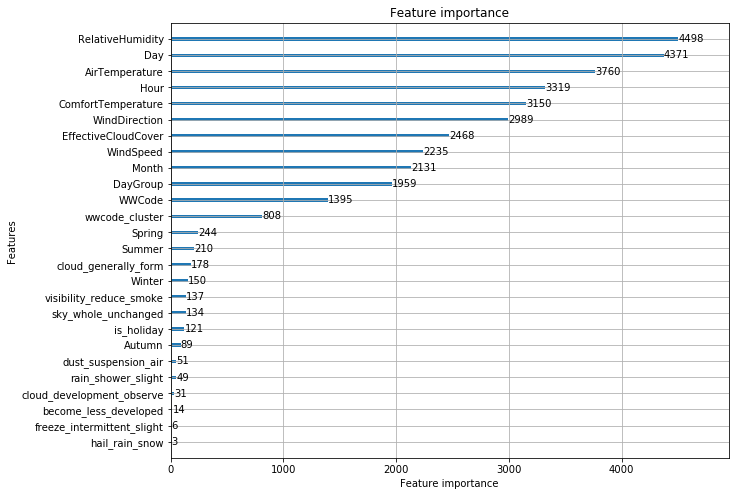

In [844]:
plot_importance(grid_imp.best_estimator_, figsize=(10, 8));

In [797]:
#Lagged Data
X_imp_cl_train_lag = pd.read_csv('X_imp_cl_train_lag.csv', index_col='DateTime', parse_dates=['DateTime'] )
X_imp_cl_val_lag = pd.read_csv('X_imp_cl_val_lag.csv', index_col='DateTime', parse_dates=['DateTime'])
X_imp_cl_val_lag = X_imp_cl_val_lag.rename(columns={'var1(t-24)': 'generation_t_24'})
y_imp_cl_train_lag = pd.read_csv('y_imp_cl_train_lag.csv', index_col='DateTime', parse_dates=['DateTime'])
y_imp_cl_val_lag = pd.read_csv('y_imp_cl_val_lag.csv', index_col='DateTime', parse_dates=['DateTime'])
X_imp_cl_test_lag = pd.read_csv('X_imp_cl_test_lag.csv', index_col='DateTime', parse_dates=['DateTime'])

In [798]:
model_list = [LGBMRegressor(n_jobs=-1, random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), 
              XGBRegressor(n_jobs=-1, random_state=42, objective='reg:squarederror'),ExtraTreesRegressor(random_state=42), 
              GradientBoostingRegressor(random_state=42), BaggingRegressor(random_state=42)
             ]

train_rmses = []
train_maes = []
train_r2s = []
val_rmses = []
val_maes = []
val_r2s = []
times = []
counter = 0

print("Prediction started...")
for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(X_imp_cl_train_lag, np.ravel(y_imp_cl_train_lag))
    end_time = time.time()
    train_pred = mod.predict(X_imp_cl_train_lag)
    val_pred = mod.predict(X_imp_cl_val_lag)
    
    train_rmses.append(mean_squared_error(np.ravel(y_imp_cl_train_lag), train_pred, squared=False))
    train_maes.append(mean_absolute_error(np.ravel(y_imp_cl_train_lag), train_pred))
    train_r2s.append(r2_score(np.ravel(y_imp_cl_train_lag), train_pred))
    
    val_rmses.append(mean_squared_error(np.ravel(y_imp_cl_val_lag), val_pred, squared=False))
    val_maes.append(mean_absolute_error(np.ravel(y_imp_cl_val_lag), val_pred))
    val_r2s.append(r2_score(np.ravel(y_imp_cl_val_lag), val_pred))

    times.append(end_time - start_time)
    print("Model",counter,"is completed")
    counter += 1
print("Prediction is completed...")    

Prediction started...
Model 0 is completed
Model 1 is completed
Model 2 is completed
Model 3 is completed
Model 4 is completed
Model 5 is completed
Prediction is completed...


In [799]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_rmse': train_rmses,
     'train_mae': train_maes,
     'train_r2': train_r2s,
     'val_rmse': val_rmses,
     'val_mae': val_maes,
     'val_r2': val_r2s,   
     'duration': times
    })

modelsdf.sort_values(by='val_rmse', ascending=True)

,model,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2,duration
0,LGBMRegressor(random_state=42),1.691996e+01,8.679511e+00,0.981865,25.499875,12.411016,0.962770,0.563010
4,([DecisionTreeRegressor(criterion='friedman_ms...,2.364537e+01,1.219790e+01,0.964582,26.220517,13.414814,0.960636,5.877019
3,"(ExtraTreeRegressor(random_state=1608637542), ...",2.098925e-13,1.061159e-13,1.000000,26.284074,12.991994,0.960445,18.067032
2,"XGBRegressor(n_jobs=-1, objective='reg:squared...",2.370446e+01,1.226705e+01,0.964405,26.408466,13.599756,0.960069,4.559192
1,"(DecisionTreeRegressor(max_features='auto', ra...",8.479797e+00,4.108839e+00,0.995445,26.744797,13.303943,0.959046,6.045621
5,(DecisionTreeRegressor(random_state=1952926171...,1.028931e+01,4.713747e+00,0.993293,28.275186,14.113429,0.954225,2.906969


In [809]:
X_imp_cl_train_lag_filtered = X_imp_cl_train_lag.drop(['Autumn_t',
       'Spring_t', 'Summer_t', 'Winter_t',
       'become_less_developed_t', 'cloud_development_observe_t',
       'cloud_generally_dissolve_t', 'cloud_generally_form_t',
       'development_observe_observable_t', 'dissolve_become_less_t',
       'dust_suspension_air_t', 'fall_snowflake_slight_t',
       'freeze_intermittent_slight_t', 'generally_dissolve_become_t',
       'generally_form_develop_t', 'hail_rain_snow_t',
       'moderate_without_hail_t', 'rain_freeze_intermittent_t',
       'rain_shower_slight_t', 'sky_whole_unchanged_t',
       'slight_moderate_without_t', 'state_sky_whole_t',
       'thunderstorm_slight_moderate_t', 'visibility_reduce_smoke_t',
       'widespread_dust_suspension_t', 'without_hail_rain_t'], axis=1)

X_imp_cl_val_lag_filtered = X_imp_cl_val_lag.drop(['Autumn_t',
       'Spring_t', 'Summer_t', 'Winter_t',
       'become_less_developed_t', 'cloud_development_observe_t',
       'cloud_generally_dissolve_t', 'cloud_generally_form_t',
       'development_observe_observable_t', 'dissolve_become_less_t',
       'dust_suspension_air_t', 'fall_snowflake_slight_t',
       'freeze_intermittent_slight_t', 'generally_dissolve_become_t',
       'generally_form_develop_t', 'hail_rain_snow_t',
       'moderate_without_hail_t', 'rain_freeze_intermittent_t',
       'rain_shower_slight_t', 'sky_whole_unchanged_t',
       'slight_moderate_without_t', 'state_sky_whole_t',
       'thunderstorm_slight_moderate_t', 'visibility_reduce_smoke_t',
       'widespread_dust_suspension_t', 'without_hail_rain_t'], axis=1)

In [810]:
model_list = [LGBMRegressor(n_jobs=-1, random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), 
              XGBRegressor(n_jobs=-1, random_state=42, objective='reg:squarederror'),ExtraTreesRegressor(random_state=42), 
              GradientBoostingRegressor(random_state=42), BaggingRegressor(random_state=42)
             ]

train_rmses = []
train_maes = []
train_r2s = []
val_rmses = []
val_maes = []
val_r2s = []
times = []
counter = 0

print("Prediction started...")
for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(X_imp_cl_train_lag_filtered, np.ravel(y_imp_cl_train_lag))
    end_time = time.time()
    train_pred = mod.predict(X_imp_cl_train_lag_filtered)
    val_pred = mod.predict(X_imp_cl_val_lag_filtered)
    
    train_rmses.append(mean_squared_error(np.ravel(y_imp_cl_train_lag), train_pred, squared=False))
    train_maes.append(mean_absolute_error(np.ravel(y_imp_cl_train_lag), train_pred))
    train_r2s.append(r2_score(np.ravel(y_imp_cl_train_lag), train_pred))
    
    val_rmses.append(mean_squared_error(np.ravel(y_imp_cl_val_lag), val_pred, squared=False))
    val_maes.append(mean_absolute_error(np.ravel(y_imp_cl_val_lag), val_pred))
    val_r2s.append(r2_score(np.ravel(y_imp_cl_val_lag), val_pred))

    times.append(end_time - start_time)
    print("Model",counter,"is completed")
    counter += 1
print("Prediction is completed...")    

Prediction started...
Model 0 is completed
Model 1 is completed
Model 2 is completed
Model 3 is completed
Model 4 is completed
Model 5 is completed
Prediction is completed...


In [811]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_rmse': train_rmses,
     'train_mae': train_maes,
     'train_r2': train_r2s,
     'val_rmse': val_rmses,
     'val_mae': val_maes,
     'val_r2': val_r2s,   
     'duration': times
    })

modelsdf.sort_values(by='val_rmse', ascending=True)

,model,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2,duration
0,LGBMRegressor(random_state=42),1.702340e+01,8.741866e+00,0.981642,25.000677,12.221443,0.964213,0.493995
3,"(ExtraTreeRegressor(random_state=1608637542), ...",2.098925e-13,1.061159e-13,1.000000,25.749358,12.754971,0.962038,12.323977
2,"XGBRegressor(n_jobs=-1, objective='reg:squared...",2.391697e+01,1.223503e+01,0.963764,26.143264,13.368112,0.960867,2.194971
4,([DecisionTreeRegressor(criterion='friedman_ms...,2.386124e+01,1.225258e+01,0.963933,26.285189,13.546356,0.960441,4.743006
1,"(DecisionTreeRegressor(max_features='auto', ra...",8.582807e+00,4.162435e+00,0.995334,26.660854,13.371014,0.959303,5.259995
5,(DecisionTreeRegressor(random_state=1952926171...,1.044991e+01,4.802196e+00,0.993082,27.898656,13.941053,0.955436,2.315997


In [ ]:
#scale the target

In [836]:
from sklearn.preprocessing import RobustScaler, 
target_scaler = RobustScaler(quantile_range=(5.0, 90.0))
y_imp_cl_train_lags_scaled = target_scaler.fit_transform(y_imp_cl_train_lag)
y_imp_cl_val_lags_scaled = target_scaler.transform(y_imp_cl_val_lag)

In [837]:
model_list = [LGBMRegressor(n_jobs=-1, random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), 
              XGBRegressor(n_jobs=-1, random_state=42, objective='reg:squarederror'),ExtraTreesRegressor(random_state=42), 
              GradientBoostingRegressor(random_state=42), BaggingRegressor(random_state=42)
             ]

train_rmses = []
train_maes = []
train_r2s = []
val_rmses = []
val_maes = []
val_r2s = []
times = []
counter = 0

print("Prediction started...")
for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(X_imp_cl_train_lag_filtered, np.ravel(y_imp_cl_train_lags_scaled))
    end_time = time.time()
    train_pred = mod.predict(X_imp_cl_train_lag_filtered)
    val_pred = mod.predict(X_imp_cl_val_lag_filtered)
    
    train_pred_inv = target_scaler.inverse_transform(train_pred.reshape(-1, 1))
    val_pred_inv = target_scaler.inverse_transform(val_pred.reshape(-1, 1))
    
    train_rmses.append(mean_squared_error(np.ravel(y_imp_cl_train_lag), train_pred_inv, squared=False))
    train_maes.append(mean_absolute_error(np.ravel(y_imp_cl_train_lag), train_pred_inv))
    train_r2s.append(r2_score(np.ravel(y_imp_cl_train_lag), train_pred_inv))
    
    val_rmses.append(mean_squared_error(np.ravel(y_imp_cl_val_lag), val_pred_inv, squared=False))
    val_maes.append(mean_absolute_error(np.ravel(y_imp_cl_val_lag), val_pred_inv))
    val_r2s.append(r2_score(np.ravel(y_imp_cl_val_lag), val_pred_inv))

    times.append(end_time - start_time)
    print("Model",counter,"is completed")
    counter += 1
print("Prediction is completed...")    

Prediction started...
Model 0 is completed
Model 1 is completed
Model 2 is completed
Model 3 is completed
Model 4 is completed
Model 5 is completed
Prediction is completed...


In [838]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_rmse': train_rmses,
     'train_mae': train_maes,
     'train_r2': train_r2s,
     'val_rmse': val_rmses,
     'val_mae': val_maes,
     'val_r2': val_r2s,   
     'duration': times
    })

modelsdf.sort_values(by='val_rmse', ascending=True)

,model,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2,duration
0,LGBMRegressor(random_state=42),1.702340e+01,8.741866e+00,0.981642,25.000677,12.221443,0.964213,0.492030
3,"(ExtraTreeRegressor(random_state=1608637542), ...",4.627303e-11,5.370054e-13,1.000000,25.955147,12.825396,0.961429,12.517713
4,([DecisionTreeRegressor(criterion='friedman_ms...,2.386124e+01,1.225258e+01,0.963933,26.285189,13.546356,0.960441,5.123056
2,"XGBRegressor(n_jobs=-1, objective='reg:squared...",2.389819e+01,1.227153e+01,0.963821,26.381936,13.636554,0.960150,3.014445
1,"(DecisionTreeRegressor(max_features='auto', ra...",8.583176e+00,4.159589e+00,0.995333,26.669539,13.341634,0.959276,4.940490
5,(DecisionTreeRegressor(random_state=1952926171...,1.047265e+01,4.799104e+00,0.993052,28.182309,14.132344,0.954525,2.552037


In [ ]:
#Extract monthly, daily and hourly averages, max, min generations

In [898]:
print(y_imp_cl_train_lag.shape)
print(y_imp_cl_val_lag.shape)
print(y_lagged.shape)

(23352, 1)
(2184, 1)
(25560, 2)


In [901]:
#X_imp_cl_train_lag_filtered
y_averages = y_new[y_new.index.isin(pd.concat([X_imp_cl_train_lag_filtered, X_imp_cl_val_lag_filtered], axis=0).index)].copy()
y_averages["year"] = y_averages.index.year
y_averages["month"] = y_averages.index.month
y_averages["day"] = y_averages.index.day
y_averages["hour"] = y_averages.index.hour

In [903]:
monthly_averages = y_averages[['month', "Generation"]]
monthly_averages2 = monthly_averages.groupby('month').expanding()["Generation"].agg(['max', 'min', 'mean'])
monthly_averages2 = monthly_averages2.reset_index().set_index('DateTime').rename(columns={'max': 'monthly_cummax',
                                                                      'min': 'monthly_cummin',
                                                                      'mean': 'monthly_cummean'
                                                                     }).drop('month', axis=1)

yearly_averages = y_averages[['year', "Generation"]]
yearly_averages2 = yearly_averages.groupby('year').expanding()["Generation"].agg(['max', 'min', 'mean'])
yearly_averages2 = yearly_averages2.reset_index().set_index('DateTime').rename(columns={'max': 'yearly_cummax',
                                                                      'min': 'yearly_cummin',
                                                                      'mean': 'yearly_cummean'
                                                                     }).drop('year', axis=1)

daily_averages = y_averages[['day', "Generation"]]
daily_averages2 = daily_averages.groupby('day').expanding()["Generation"].agg(['max', 'min', 'mean'])
daily_averages2 = daily_averages2.reset_index().set_index('DateTime').rename(columns={'max': 'daily_cummax',
                                                                      'min': 'daily_cummin',
                                                                      'mean': 'daily_cummean'
                                                                     }).drop('day', axis=1)

hourly_averages = y_averages[['hour', "Generation"]]
hourly_averages2 = hourly_averages.groupby('hour').expanding()["Generation"].agg(['max', 'min', 'mean'])
hourly_averages2 = hourly_averages2.reset_index().set_index('DateTime').rename(columns={'max': 'hourly_max',
                                                                      'min': 'hourly_min',
                                                                      'mean': 'hourly_mean'
                                                                     }).drop('hour', axis=1)

averages = pd.concat([yearly_averages2, monthly_averages2, daily_averages2, hourly_averages2], axis=1)

In [904]:
X_imp_cl_train_lag_filtered2 = X_imp_cl_train_lag_filtered.merge(averages, left_index=True, right_index=True, how='left')
X_imp_cl_val_lag_filtered2 = X_imp_cl_val_lag_filtered.merge(averages, left_index=True, right_index=True, how='left')

print(X_imp_cl_train_lag_filtered2.shape)
print(X_imp_cl_val_lag_filtered2.shape)

(23352, 32)
(2184, 32)


In [908]:
from sklearn.preprocessing import RobustScaler
feature_scaler = RobustScaler(quantile_range=(25.0, 75.0))
X_imp_cl_train_lag_filtered2_scaled = feature_scaler.fit_transform(X_imp_cl_train_lag_filtered2)
X_imp_cl_val_lag_filtered2_scaled = feature_scaler.transform(X_imp_cl_val_lag_filtered2)

In [909]:
model_list = [LGBMRegressor(n_jobs=-1, random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), 
              XGBRegressor(n_jobs=-1, random_state=42, objective='reg:squarederror'),ExtraTreesRegressor(random_state=42), 
              GradientBoostingRegressor(random_state=42), BaggingRegressor(random_state=42)
             ]

train_rmses = []
train_maes = []
train_r2s = []
val_rmses = []
val_maes = []
val_r2s = []
times = []
counter = 0

print("Prediction started...")
for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(X_imp_cl_train_lag_filtered2_scaled, np.ravel(y_imp_cl_train_lags_scaled))
    end_time = time.time()
    train_pred = mod.predict(X_imp_cl_train_lag_filtered2_scaled)
    val_pred = mod.predict(X_imp_cl_val_lag_filtered2_scaled)
    
    train_pred_inv = target_scaler.inverse_transform(train_pred.reshape(-1, 1))
    val_pred_inv = target_scaler.inverse_transform(val_pred.reshape(-1, 1))
    
    train_rmses.append(mean_squared_error(np.ravel(y_imp_cl_train_lag), train_pred_inv, squared=False))
    train_maes.append(mean_absolute_error(np.ravel(y_imp_cl_train_lag), train_pred_inv))
    train_r2s.append(r2_score(np.ravel(y_imp_cl_train_lag), train_pred_inv))
    
    val_rmses.append(mean_squared_error(np.ravel(y_imp_cl_val_lag), val_pred_inv, squared=False))
    val_maes.append(mean_absolute_error(np.ravel(y_imp_cl_val_lag), val_pred_inv))
    val_r2s.append(r2_score(np.ravel(y_imp_cl_val_lag), val_pred_inv))

    times.append(end_time - start_time)
    print("Model",counter,"is completed")
    counter += 1
print("Prediction is completed...")    

Prediction started...
Model 0 is completed
Model 1 is completed
Model 2 is completed
Model 3 is completed
Model 4 is completed
Model 5 is completed
Prediction is completed...


In [910]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_rmse': train_rmses,
     'train_mae': train_maes,
     'train_r2': train_r2s,
     'val_rmse': val_rmses,
     'val_mae': val_maes,
     'val_r2': val_r2s,   
     'duration': times
    })

modelsdf.sort_values(by='val_rmse', ascending=True)

,model,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2,duration
3,"(ExtraTreeRegressor(random_state=1608637542), ...",1.580539e-09,3.404948e-11,1.000000,26.107049,12.812512,0.960976,16.179961
0,LGBMRegressor(random_state=42),1.455513e+01,7.470629e+00,0.986580,26.950867,13.157561,0.958412,0.684998
2,"XGBRegressor(n_jobs=-1, objective='reg:squared...",2.156950e+01,1.122674e+01,0.970528,27.754787,14.573128,0.955894,4.036694
4,([DecisionTreeRegressor(criterion='friedman_ms...,2.160600e+01,1.124163e+01,0.970428,28.110428,16.220833,0.954757,8.527995
1,"(DecisionTreeRegressor(max_features='auto', ra...",7.368613e+00,3.520487e+00,0.996560,31.454764,15.958464,0.943351,8.140064
5,(DecisionTreeRegressor(random_state=1952926171...,9.000326e+00,4.052940e+00,0.994869,32.949776,16.668187,0.937838,3.872997


In [911]:
y_imp_cl_train_lag

,Generation
DateTime,
2019-01-02 00:00:00,0.000008
2019-01-02 01:00:00,0.000000
2019-01-02 02:00:00,0.000000
2019-01-02 03:00:00,0.000008
2019-01-02 04:00:00,0.000000
...,...
2021-08-31 19:00:00,1.064835
2021-08-31 20:00:00,0.009499
2021-08-31 21:00:00,0.000000


In [912]:
lgbm_imp2 = LGBMRegressor(n_jobs=-1, random_state=42)


params2 = {
    "boosting_type": ['gbdt'],
    "n_estimators": [500, 1000],
    "min_split_gain": [0.00001, 0.0001],
    "min_child_samples":[5, 10],
    "max_depth": [10, 15, 50],
    "learning_rate": [0.1, 0.01],
    "num_leaves": [50, 70, 100]   
}


#define mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

grid_imp2 = GridSearchCV(lgbm_imp2, param_grid=params2, cv=3, n_jobs=-1, scoring=mse, verbose=1)
grid_imp2.fit(X_imp_cl_train_lag_filtered2_scaled, np.ravel(y_imp_cl_train_lags_scaled))

print(grid_imp2.best_params_)

y_train_grid_imp2 = grid_imp2.predict(X_imp_cl_train_lag_filtered2_scaled)
y_val_grid_imp2 = grid_imp2.predict(X_imp_cl_val_lag_filtered2_scaled)

train_pred_inv2 = target_scaler.inverse_transform(y_train_grid_imp2.reshape(-1, 1))
val_pred_inv2 = target_scaler.inverse_transform(y_val_grid_imp2.reshape(-1, 1))


print("Train Set RMSE:", mean_squared_error(y_imp_cl_train_lag, train_pred_inv2, squared=False))
print("Train Set MAE:", mean_absolute_error(y_imp_cl_train_lag, train_pred_inv2))
print("Train Set R2:", r2_score(y_imp_cl_train_lag, train_pred_inv2))

print()
print("Val Set RMSE:", mean_squared_error(y_imp_cl_val_lag, val_pred_inv2, squared=False))
print("Val Set MAE:", mean_absolute_error(y_imp_cl_val_lag, val_pred_inv2))
print("Val Set R2:", r2_score(y_imp_cl_val_lag, val_pred_inv2))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 10.0min finished


{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 50, 'min_child_samples': 5, 'min_split_gain': 0.0001, 'n_estimators': 1000, 'num_leaves': 50}
Train Set RMSE: 11.696352991023993
Train Set MAE: 6.134007215463198
Train Set R2: 0.9913338364567597

Val Set RMSE: 26.855968941696226
Val Set MAE: 13.069088516360315
Val Set R2: 0.9587046554780029
